# Cours/TP: Entraînement d’un Réseau de Neurones avec Keras


Dans ce notebook, nous allons consolider nos connaissances sur l’entraînement d’un réseau de neurones artificiel. Nous allons :

1. Charger et prétraiter le dataset **Fashion-MNIST**, très similaire à MNIST mais avec des images de vêtements et d’accessoires.
2. Construire un réseau de neurones avec `tf.keras` (Sequential API).
3. Comprendre les paramètres dans `Sequential()`, `.compile()` et `.fit()`.
4. Discuter des aspects théoriques importants : rétropropagation, vanishing et exploding gradients.
5. Discuter de l’impact des méthodes d’initialisation (He, Xavier, etc.)
6. Conclure sur l’importance et l’usage du **transfer learning**.



In [1]:
# Installation et import des librairies si besoin (dans Colab, c'est souvent déjà présent)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

## Chargement du Dataset : Fashion-MNIST

Le dataset Fashion-MNIST est un ensemble de 70,000 images (28x28 pixels, en niveaux de gris) représentant des articles de mode (chaussures, t-shirts, sacs, etc.). Il est souvent utilisé comme un "remplaçant" de MNIST pour tester des modèles de vision, car il est un peu plus complexe mais garde le même format pratique.

### Étapes :

1. **Chargement des données** : Nous allons charger via `keras.datasets`.
2. **Division entre train et test** : Fashion-MNIST est déjà divisé : `x_train, y_train` (données d’entraînement), `x_test, y_test` (données de test).
3. **Normalisation** : Les images sont codées sur 0-255. On va les normaliser entre 0 et 1.
4. **Encodage des étiquettes** : Ici, les étiquettes sont déjà des entiers de 0 à 9. Pour un réseau de neurones en classification, on peut garder la codification entière, Keras gère cela nativement via la sparse_categorical_crossentropy, ou on peut faire du one-hot encoding. Nous allons utiliser la forme entière, plus simple.


In [2]:
# Chargement du dataset Fashion-MNIST
fashion_mnist = keras.datasets.fashion_mnist
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Normalisation [0,1]
x_train = x_train / 255.0
x_test = x_test / 255.0

# Dimensions des données
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
x_train shape: (60000, 28, 28)
y_train shape: (60000,)


Les données `x_train` sont de forme (60000, 28, 28) et les étiquettes `y_train` (60000,).  
Pareil pour `x_test` : (10000, 28, 28).

La normalisation entre 0 et 1 permet une convergence plus stable lors de l’entraînement.

### Affichage de quelques exemples
Il est souvent instructif de visualiser quelques images pour se faire une idée des données.

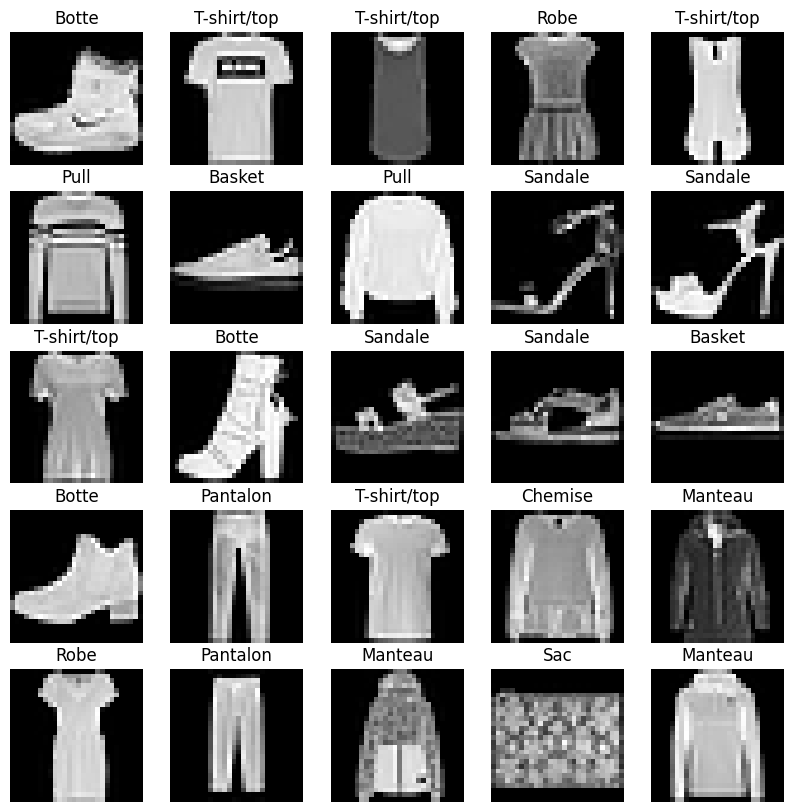

In [3]:
# Affichage de quelques exemples
class_names = ["T-shirt/top", "Pantalon", "Pull", "Robe", "Manteau", "Sandale", "Chemise", "Basket", "Sac", "Botte"]

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(x_train[i], cmap='gray')
    plt.title(class_names[y_train[i]])
    plt.axis('off')
plt.show()

## Construction du Réseau de Neurones (NN) avec Keras

Nous allons construire un réseau de neurones simple, basé sur l’API Sequential de Keras. Il s’agit d’une pile de couches (`layers`) appliquées les unes après les autres. Les images sont en 2D (28x28). Pour un réseau fully-connected "classique", nous allons d’abord aplatir l’image en un vecteur de taille 784 (28*28).

### Les Couches :

- **Flatten** : Transforme une image 2D en un vecteur 1D.
- **Dense** : Couche pleinement connectée. Chaque neurone de la couche dense est connecté à tous les neurones de la couche précédente.

### Les Paramètres des Couches :

- `units` (pour Dense) : nombre de neurones dans la couche.
- `activation` : fonction d’activation (relu, sigmoid, softmax...).  
  - **relu (Rectified Linear Unit)** est très courant, il renvoie `max(0, x)`.  
  - **softmax** est utilisée en sortie pour la classification multi-classes, elle transforme les valeurs en probabilités.
- `input_shape` : forme de l’entrée. On la précise souvent sur la première couche afin que Keras sache la taille des données.

### Fonctions d’Activation et Problèmes de Gradients :

- **Vanishing gradient** : Lorsque les gradients deviennent très petits, l’apprentissage stagne. Les anciennes fonctions comme sigmoid saturent rapidement.
- **Exploding gradient** : Lorsque les gradients explosent, la mise à jour des poids devient instable.
  
L’utilisation de ReLU et d’initialisations appropriées (He, Xavier) atténue ces problèmes. ReLU n’est pas parfaite mais réduit considérablement l’effet "vanishing" par rapport à sigmoid ou tanh, surtout dans des couches profondes.

### Initialisation des Poids :

- **Xavier (Glorot) initialization** : adaptée pour des couches utilisant tanh ou sigmoid.
- **He initialization** : plus adaptée aux activations ReLU. Elle maintient la variance du signal à travers les couches, évitant ainsi que les gradients ne disparaissent ou n’explosent.

Par défaut, Keras utilise une initialisation adaptée (Glorot uniform en général) mais on peut spécifier `kernel_initializer="he_normal"` par exemple si on le souhaite.

Nous allons créer un réseau avec :

- Une couche Flatten en entrée
- Deux couches Dense cachées avec ReLU
- Une couche de sortie Dense avec softmax

In [4]:
model = keras.Sequential([
    # Flatten: à partir d'une image 28x28, crée un vecteur 784. (Pas de paramètres d'activation ici, c'est juste un remodelage.)
    layers.Flatten(input_shape=(28,28)),

    # Couche cachée 1: Dense, 128 neurones, activation relu
    # Cette couche a beaucoup de paramètres : chaque neurone est relié aux 784 entrées du Flatten.
    # Keras gère l'initialisation des poids. On pourrait explicitement mettre:
    # kernel_initializer='he_normal' pour He init. Par défaut il utilise glorot_uniform.
    layers.Dense(128, activation='relu'),

    # Couche cachée 2: Dense, 64 neurones, activation relu
    layers.Dense(64, activation='relu'),

    # Couche de sortie: 10 neurones (10 classes), activation softmax
    # softmax va transformer le vecteur de sortie en distribution de probabilités.
    layers.Dense(10, activation='softmax')
])

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         100,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 109,386 (427.29 KB)

 Trainable params: 109,386 (427.29 KB)

 Non-trainable params: 0 (0.00 B)

La fonction `model.summary()` permet de voir le nombre de paramètres entraînables.  
Ce réseau n’est pas trop profond, mais déjà plus complexe qu’un réseau linéaire.

## Compilation du Modèle

Avant l’entraînement, il faut **compiler** le modèle. Cela consiste à définir :

- **loss** (fonction de perte) : mesure l’écart entre la prédiction du réseau et la vérité terrain. On utilise ici `sparse_categorical_crossentropy` car nos labels sont des entiers et notre sortie est une softmax.
- **optimizer** : la méthode d’optimisation (ex : `adam`). Adam est un optimiseur adaptatif très utilisé, il ajuste les learning rates de chaque poids individuellement.
- **metrics** : métriques à surveiller, par exemple `accuracy`.

### Choix du loss

`"sparse_categorical_crossentropy"` est utilisé parce que nos étiquettes sont sous forme d'entiers. Si on avait fait un one-hot encoding, on aurait utilisé `"categorical_crossentropy"`.

### Choix de l’optimizer

- **Adam** : combine les idées d’Adagrad et RMSProp, ajuste dynamiquement les taux d’apprentissage. Très courant et efficace par défaut.

### Rétropropagation (Backpropagation)

L’entraînement d’un réseau s’effectue par rétropropagation du gradient, c’est-à-dire :

1. On fait une passe avant (forward pass) : on calcule la sortie du réseau.
2. On calcule la perte (loss) en comparant prédiction et label.
3. On calcule le gradient de la perte par rapport aux poids (via la rétropropagation).
4. On met à jour les poids selon l’optimiseur (par ex. Adam).

Ainsi, le réseau ajuste ses paramètres pour réduire la perte sur l’ensemble d’entraînement.

### Problèmes de Vanishing/Exploding Gradients

Sur de très grands réseaux, le gradient peut :
- Disparaître (vanishing) : les couches proches de l’entrée ne reçoivent presque plus de mise à jour, l’apprentissage est lent.
- Exploser (exploding) : les poids deviennent immenses, entraînant une divergence.

Des techniques comme l’utilisation de ReLU, batch normalization, ou le choix d’un initialiseur de poids adéquat (He, Xavier) aident à limiter ces problèmes.

In [5]:
# Compilation du modèle avec:
# - Loss: sparse_categorical_crossentropy (pour classification multi-classes)
# - Optimizer: adam
# - Metric: accuracy (mesure facile de performance)
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

#### Extra (1): `sparse_categorical_crossentropy`

La fonction `sparse_categorical_crossentropy` est une mesure d'erreur utilisée dans les modèles de machine learning pour résoudre des problèmes de classification multi-classes, où chaque exemple appartient à une seule classe parmi plusieurs possibles. Elle compare les prédictions du modèle (sous forme de probabilités pour chaque classe) avec les étiquettes réelles des données. Contrairement à `categorical_crossentropy`, qui nécessite que les étiquettes soient encodées sous forme de vecteurs one-hot (par exemple, [0, 1, 0] pour une classe), `sparse_categorical_crossentropy` accepte directement les étiquettes comme entiers (par exemple, 1 pour la deuxième classe). Cela simplifie la préparation des données et est plus efficace en mémoire, car il n'est pas nécessaire de convertir les étiquettes en vecteurs. Cette fonction est souvent utilisée dans les problèmes de classification avec des réseaux de neurones, comme la reconnaissance d'images ou la classification de texte.

#### Extra (2): `Accuracy` vs `Loss` : Comprendre la différence

En machine learning, accuracy et loss sont deux métriques importantes mais distinctes pour évaluer un modèle :

1. Loss (Erreur) :
La perte (loss) est une mesure de l'erreur d'un modèle pendant l'entraînement. Elle indique à quel point les prédictions du modèle s'écartent des valeurs réelles. Une faible perte signifie que le modèle fait de bonnes prédictions sur les données d'entraînement. Les fonctions comme mean_squared_error ou categorical_crossentropy calculent cette erreur en tenant compte des probabilités et des écarts entre prédictions et étiquettes réelles.

2. Accuracy (Précision) :
L’accuracy est une mesure plus intuitive qui représente le pourcentage de prédictions correctes faites par le modèle sur l’ensemble des données. Par exemple, une précision de 90 % signifie que le modèle fait des prédictions correctes dans 90 % des cas. Contrairement à la perte, elle ne considère pas à quel point une prédiction est "proche" de la bonne réponse, seulement si elle est correcte ou non.

**Différences clés :**

- La loss est utilisée pour optimiser le modèle pendant l'entraînement, car elle donne une mesure continue et différentiable, essentielle pour la rétropropagation.
- L’accuracy est généralement utilisée pour interpréter la performance globale du modèle d’une manière compréhensible par les humains.

## Entraînement du Modèle

L’entraînement se fait avec la méthode `.fit()`. Paramètres principaux :

- `x` et `y`: données d’entraînement et labels.
- `epochs`: nombre de passes complètes sur le dataset.
- `batch_size`: nombre d’exemples par mise à jour de gradient. Par défaut, Keras utilise 32.
- `validation_split`: fraction des données d’entraînement à utiliser pour la validation. Permet de surveiller le sur-apprentissage.

Ici, on va entraîner le réseau sur 10 époques, ce qui est généralement suffisant pour un premier essai sur Fashion-MNIST.

In [6]:
history = model.fit(
    x_train,
    y_train,
    epochs=10,       # nombre d'itérations sur l'ensemble du dataset
    batch_size=32,   # taille de batch (par défaut 32, on peut varier)
    validation_split=0.1  # 10% des données d'entrainement utilisées pour la validation
)

Epoch 1/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.7598 - loss: 0.6768 - val_accuracy: 0.8563 - val_loss: 0.3864
Epoch 2/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8634 - loss: 0.3751 - val_accuracy: 0.8705 - val_loss: 0.3630
Epoch 3/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8734 - loss: 0.3452 - val_accuracy: 0.8740 - val_loss: 0.3494
Epoch 4/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8836 - loss: 0.3112 - val_accuracy: 0.8810 - val_loss: 0.3189
Epoch 5/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8937 - loss: 0.2896 - val_accuracy: 0.8795 - val_loss: 0.3349
Epoch 6/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8943 - loss: 0.2803 - val_accuracy: 0.8812 - val_loss: 0.3266
Epoch 7/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8988 - loss: 0.2676 - val_accuracy: 0.8862 - val_loss: 0.3268
Epoch 8/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9061 - loss: 0.2522 - 

## Analyse des Résultats de l’Entraînement

La méthode `.fit()` retourne un objet `history` contenant l’évolution du loss et des métriques sur l’entraînement et la validation. On peut tracer ces courbes pour juger du comportement.

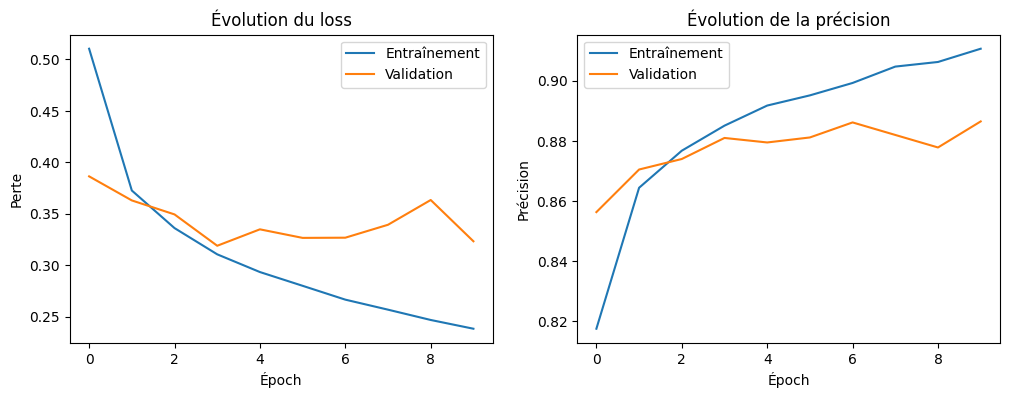

In [7]:
# Evolution de la perte et de la précision pendant l'entraînement
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Entraînement')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Évolution du loss')
plt.xlabel('Époch')
plt.ylabel('Perte')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Entraînement')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Évolution de la précision')
plt.xlabel('Époch')
plt.ylabel('Précision')
plt.legend()

plt.show()

Idéalement, la perte diminue et la précision augmente sur l’ensemble d’entraînement. Sur la validation, c’est aussi le cas dans les premières époques, puis on peut détecter un sur-apprentissage si la validation stagne ou se dégrade.

Maintenant, évaluons le modèle sur les données de test.

In [8]:
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)
print("Perte sur le test:", test_loss)
print("Précision sur le test:", test_accuracy)

Perte sur le test: 0.342929869890213
Précision sur le test: 0.8848000168800354


# Transfer Learning

Le **Transfer Learning** est une méthode où un modèle déjà entraîné sur un grand dataset (comme **ImageNet**) est réutilisé pour une nouvelle tâche.  
Cela permet de tirer parti des connaissances acquises par le modèle pré-entraîné pour des problèmes spécifiques, ce qui est particulièrement utile lorsque :
- Le dataset disponible est limité.
- Vous n'avez pas les ressources nécessaires pour entraîner un modèle complexe depuis zéro.

Dans cette section, nous allons :
1. Charger un modèle pré-entraîné (**VGG16**) et comprendre sa structure.
2. Ajouter des couches pour adapter le modèle à notre problème.
3. Utiliser un générateur de données (**ImageDataGenerator**) pour charger et prétraiter notre dataset.
4. Entraîner le modèle et analyser ses performances.


## Qu'est-ce que VGG16 ?

**VGG16** est un modèle de réseau de neurones convolutif (CNN) conçu pour résoudre des tâches de classification d'images.  
Il a été entraîné sur **ImageNet**, un dataset contenant plus d'un million d'images réparties sur 1000 classes.

Caractéristiques principales de **VGG16** :
- Profondeur fixe : Il a 16 couches denses et convolutives.
- Structure simple : Toutes les couches convolutives utilisent des filtres de 3x3.

En utilisant ce modèle, nous n'avons pas besoin de réapprendre les caractéristiques générales (par exemple, détection de bords, motifs simples), car il les a déjà apprises sur ImageNet. Nous allons donc :
1. **Geler** les couches du modèle pré-entraîné pour conserver ses connaissances.
2. Ajouter des **couches personnalisées** pour adapter le modèle à notre problème.

In [9]:
# Importer les bibliothèques nécessaires
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

In [10]:
# Charger le modèle pré-entraîné VGG16 sans la dernière couche (include_top=False)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Geler les couches du modèle (elles ne seront pas réentraînées)
for layer in base_model.layers:
    layer.trainable = False

# Ajouter des couches personnalisées pour notre dataset
x = Flatten()(base_model.output)  # Aplatir les caractéristiques extraites par VGG16
x = Dense(128, activation='relu')(x)  # Ajouter une couche dense avec 128 neurones
x = Dropout(0.5)(x)  # Ajouter un Dropout pour éviter le surapprentissage
output = Dense(3, activation='softmax')(x)  # Sortie avec 3 classes (softmax)

# Créer le modèle final
model = Model(inputs=base_model.input, outputs=output)

# Compiler le modèle
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 150, 150, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 150, 150, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 75, 75, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 75, 75, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 75, 75, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 37, 37, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 37, 37, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 37, 37, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 37, 37, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 18, 18, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 18, 18, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 9, 9, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │       1,048,704 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 15,763,779 (60.13 MB)

 Trainable params: 1,049,091 (4.00 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Explication du code :

1- **VGG16 :** Le modèle est chargé sans la dernière couche (include_top=False) car nous allons adapter sa sortie à notre problème.

2- **Geler les couches :** Les couches du modèle VGG16 sont gelées (trainable = False) pour ne pas altérer les connaissances acquises sur ImageNet.

3- **Couches supplémentaires :**

- Flatten : Permet de convertir les caractéristiques convolutives en un vecteur 1D utilisable par des couches denses.

- Dense : Une couche dense de 128 neurones pour apprendre des caractéristiques spécifiques à notre dataset.

- Dropout : Une régularisation pour réduire le surapprentissage en désactivant aléatoirement des neurones.

- Dernière couche dense avec softmax : Pour produire des probabilités pour chaque classe (3 classes ici).


## Préparer le Dataset avec ImageDataGenerator

`ImageDataGenerator` est une classe de Keras qui permet de charger et prétraiter facilement des images.  
Elle est utile pour :
1. **Redimensionner** les images pour qu'elles aient la même taille.
2. **Normaliser** les pixels (diviser par 255 pour que les valeurs soient entre 0 et 1).
3. **Augmenter les données** : Appliquer des transformations comme rotations, zooms, ou inversions pour améliorer la robustesse du modèle.

Nous allons utiliser `ImageDataGenerator` pour :
- Charger un dataset d'images depuis un répertoire.
- Séparer les données en ensemble d'entraînement et de validation.
- Appliquer des transformations pour augmenter la diversité des données.


In [11]:
# Le dataset Cats vs Dogs est un ensemble d’images contenant deux classes : des images de chats et des images de chiens.
# Il est souvent utilisé pour des tâches de classification binaire, où le but est de prédire si une image représente un chat ou un chien.
dataset_url = "https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip"
path_to_zip = tf.keras.utils.get_file('cats_and_dogs_filtered.zip', origin=dataset_url, extract=True)

dataset_path = path_to_zip.replace('cats_and_dogs_filtered.zip', 'cats_and_dogs_filtered')
print(f"Dataset téléchargé et extrait ici : {dataset_path}")

train_dir = f"{dataset_path}/train"
validation_dir = f"{dataset_path}/validation"

68606236/68606236 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Dataset téléchargé et extrait ici : /root/.keras/datasets/cats_and_dogs_filtered


In [12]:
# Initialiser le générateur d'images avec augmentation des données
train_datagen = ImageDataGenerator(
    rescale=1.0/255,              # Normalisation des pixels
    rotation_range=20,            # Rotation aléatoire jusqu'à 20°
    width_shift_range=0.2,        # Décalage horizontal aléatoire
    height_shift_range=0.2,       # Décalage vertical aléatoire
    shear_range=0.2,              # Transformation affine (cisaillement)
    zoom_range=0.2,               # Zoom aléatoire
    horizontal_flip=True,         # Inversion horizontale
    validation_split=0.2          # 20% des données réservées pour la validation
)

# Charger les images du dataset
train_generator = train_datagen.flow_from_directory(
    train_dir,               # Chemin du dataset
    target_size=(150, 150),        # Taille des images (entrée de VGG16)
    batch_size=32,                 # Taille du lot
    class_mode='sparse',           # Utilisation des indices de classe
    subset='training'              # Ensemble d'entraînement
)

validation_generator = train_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='sparse',
    subset='validation'            # Ensemble de validation
)

Found 1600 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


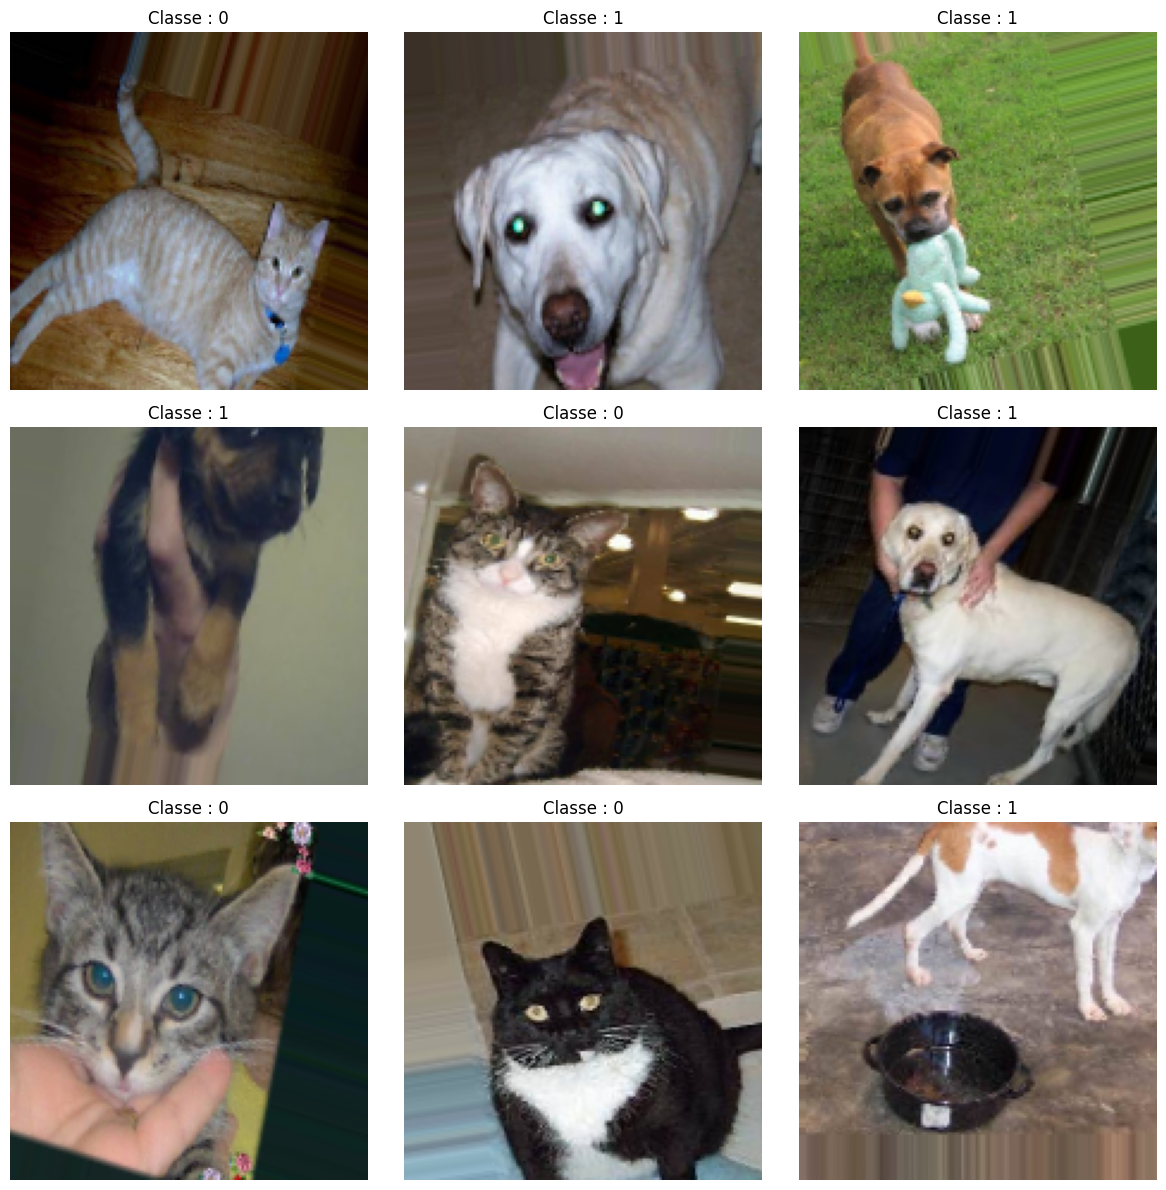

In [13]:
# Obtenir un lot d'images et leurs étiquettes depuis le générateur
sample_batch = next(train_generator)
images, labels = sample_batch

# Afficher 9 échantillons
plt.figure(figsize=(12, 12))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])  # Afficher l'image
    plt.title(f"Classe : {int(labels[i])}")  # Afficher la classe (0 ou 1)
    plt.axis('off')

plt.tight_layout()
plt.show()


Explication des paramètres :

- rescale=1.0/255 : Normalise les pixels entre 0 et 1.
- rotation_range, zoom_range, etc. : Permettent de générer des images modifiées pour enrichir le dataset.
- target_size=(150, 150) : Toutes les images sont redimensionnées à 150x150 pixels.
- validation_split=0.2 : Divise le dataset en 80% pour l'entraînement et 20% pour la validation.

## Entraîner le Modèle

Nous allons maintenant entraîner notre modèle avec :
- Le générateur d'entraînement (`train_generator`).
- Le générateur de validation (`validation_generator`).

Nous surveillerons les métriques comme l'accuracy et la loss sur les deux ensembles.


In [14]:
# Entraîner le modèle
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


50/50 ━━━━━━━━━━━━━━━━━━━━ 28s 325ms/step - accuracy: 0.5014 - loss: 0.9011 - val_accuracy: 0.7600 - val_loss: 0.4890
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 229ms/step - accuracy: 0.7441 - loss: 0.5130 - val_accuracy: 0.7900 - val_loss: 0.4575
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 250ms/step - accuracy: 0.7640 - loss: 0.4665 - val_accuracy: 0.7950 - val_loss: 0.4299
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 232ms/step - accuracy: 0.8099 - loss: 0.4205 - val_accuracy: 0.8100 - val_loss: 0.4213
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 21s 225ms/step - accuracy: 0.8245 - loss: 0.3971 - val_accuracy: 0.8300 - val_loss: 0.3947
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 21s 235ms/step - accuracy: 0.8338 - loss: 0.3802 - val_accuracy: 0.8350 - val_loss: 0.3569
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 231ms/step - accuracy: 0.8528 - loss: 0.3430 - val_accuracy: 0.8650 - val_loss: 0.3579
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 21s 229ms/step - accuracy: 0.8367 - loss: 0.3701 - val_accuracy: 0.830

## Visualiser les Performances

Nous allons analyser les courbes d'apprentissage (accuracy et loss) pour voir si le modèle converge correctement.


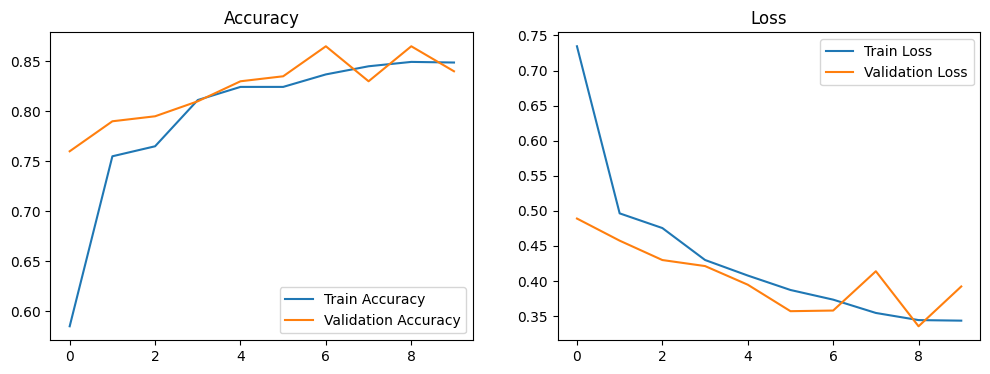

In [15]:
# Visualiser la précision et la perte
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.show()

## Tester sur une Nouvelle Image

Enfin, nous allons charger une image hors du dataset et effectuer une prédiction pour vérifier les performances du modèle.


Prédiction pour l'image de chat :


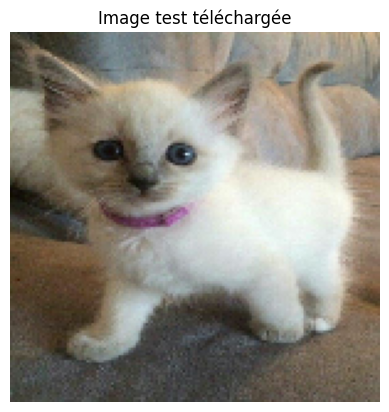

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Classe prédite : cats
Prédiction pour l'image de chien :


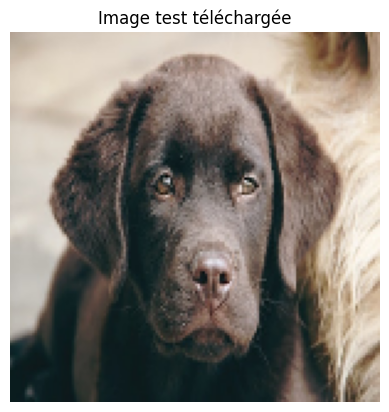

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Classe prédite : dogs


In [23]:
import requests
from tensorflow.keras.utils import load_img, img_to_array

# URL de l'image de test (remplacez par une URL d'une image de chat ou chien)
cat_test_image_url = "https://i.pinimg.com/564x/86/a2/2f/86a22feabf2a2034e93efded55c302e5.jpg"
dog_test_image_url = "https://www.oliverpetcare.com/wp-content/uploads/2020/12/pexels-helena-lopes-1790446.jpg"

# Fonction pour télécharger, afficher et prédire une image
def test_image(url, model, class_indices):
    # Télécharger l'image
    response = requests.get(url)
    if response.status_code == 200:
        with open("test_image.jpg", "wb") as f:
            f.write(response.content)

        # Charger et préparer l'image
        img = load_img("test_image.jpg", target_size=(150, 150))  # Redimensionner
        img_array = img_to_array(img) / 255.0                    # Normaliser
        img_array = img_array.reshape(1, 150, 150, 3)            # Ajouter une dimension batch

        # Afficher l'image
        plt.imshow(img)
        plt.axis('off')
        plt.title("Image test téléchargée")
        plt.show()

        # Prédire la classe
        prediction = model.predict(img_array)
        predicted_class = {v: k for k, v in class_indices.items()}  # Inverser le mapping des classes
        print(f"Classe prédite : {predicted_class[prediction.argmax()]}")
    else:
        print(f"Erreur lors du téléchargement de l'image. Code HTTP : {response.status_code}")

# Tester l'image de chat
print("Prédiction pour l'image de chat :")
test_image(cat_test_image_url, model, train_generator.class_indices)

# Tester l'image de chien
print("Prédiction pour l'image de chien :")
test_image(dog_test_image_url, model, train_generator.class_indices)